# Segmentación Semántica de Gliomas Cerebrales en Imágenes de Resonancia Magnética (MRI) utilizando Arquitecturas U-Net con Transfer Learning y Explicabilidad

Integrante: Christian Kefrey Fonseca Rodriguez

Grupo 9

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib  # Para leer archivos de formato NIfTI
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp # Biblioteca de alto nivel para modelos de segmentación
from tqdm import tqdm # Para barras de progreso
from sklearn.model_selection import train_test_split
import cv2 # OpenCV para manipulación de imágenes como redimensionamiento y superposición

# Importación de SciPy para métricas avanzadas (Distancia de Hausdorff)
from scipy.spatial.distance import cdist

# Importaciones para XAI (Grad-CAM)
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

c:\Users\chris\anaconda3\envs\vision\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuración del dispositivo (GPU si está disponible, de lo contrario CPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {DEVICE}")

Usando dispositivo: cuda


## DEFINICIÓN DE PARÁMETROS Y RUTAS

Parámetros globales para el entrenamiento y el procesamiento de datos.

In [4]:
# Ruta al directorio principal que contiene los datos de BraTS 2021
DATA_DIR = 'F:/Proyectos/brain_segmentation/data/BraTS2021_Training_Data/'

# Parámetros del modelo y entrenamiento
IMG_SIZE = 240 # Tamaño al que se redimensionarán las imágenes
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 1e-4
ENCODER = 'resnet50'
PRETRAINED_WEIGHTS = 'imagenet'

## CARGA DE DATOS Y PRE-PROCESAMIENTO

Funciones para encontrar, cargar y pre-procesar los datos de BraTS.

In [5]:
def get_patient_paths(data_dir):
    """
    Obtiene las rutas a las carpetas de cada paciente.
    """
    patient_folders = glob.glob(os.path.join(data_dir, 'BraTS2021_*'))
    return patient_folders

def preprocess_mask(mask):
    """
    Pre-procesa la máscara de segmentación de BraTS.ssss
    Las etiquetas originales son 1 (NCR), 2 (ED), 4 (ET).
    Se mapean a 1 (NCR), 2 (ED), 3 (ET) para facilitar el manejo en PyTorch.
    La clase 0 es el fondo.
    """
    mask_processed = np.zeros_like(mask)
    mask_processed[mask == 1] = 1  # NCR
    mask_processed[mask == 2] = 2  # ED
    mask_processed[mask == 4] = 3  # ET
    return mask_processed

def load_and_preprocess_sample(patient_path):
    """
    Carga las 4 modalidades de MRI y la máscara para un paciente,
    y las pre-procesa.
    Retorna una lista de pares (imagen_apilada, mascara_procesada) para los cortes con tumor.
    """
    processed_samples = []
    try:
        # Cargar las 4 modalidades y la máscara
        # glob.glob devuelve una lista, tomamos el primer elemento 
        flair_path = glob.glob(os.path.join(patient_path, '*_flair.nii.gz'))
        t1_path = glob.glob(os.path.join(patient_path, '*_t1.nii.gz'))
        t1ce_path = glob.glob(os.path.join(patient_path, '*_t1ce.nii.gz'))
        t2_path = glob.glob(os.path.join(patient_path, '*_t2.nii.gz'))
        seg_path = glob.glob(os.path.join(patient_path, '*_seg.nii.gz'))

        flair_img = nib.load(flair_path[0]).get_fdata()
        t1_img = nib.load(t1_path[0]).get_fdata()
        t1ce_img = nib.load(t1ce_path[0]).get_fdata()
        t2_img = nib.load(t2_path[0]).get_fdata()
        seg_mask = nib.load(seg_path[0]).get_fdata()

        # Iterar a través de los cortes axiales (última dimensión)
        for i in range(flair_img.shape[2]):
            mask_slice = seg_mask[:, :, i]
            
            # Solo procesar cortes que contienen tumor para enfocar el entrenamiento
            if np.sum(mask_slice) > 0:
                # Normalización Z-score para cada modalidad
                flair_slice = (flair_img[:, :, i] - np.mean(flair_img[:, :, i])) / (np.std(flair_img[:, :, i]) + 1e-8)
                t1_slice = (t1_img[:, :, i] - np.mean(t1_img[:, :, i])) / (np.std(t1_img[:, :, i]) + 1e-8)
                t1ce_slice = (t1ce_img[:, :, i] - np.mean(t1ce_img[:, :, i])) / (np.std(t1ce_img[:, :, i]) + 1e-8)
                t2_slice = (t2_img[:, :, i] - np.mean(t2_img[:, :, i])) / (np.std(t2_img[:, :, i]) + 1e-8)

                # Apilar las 4 modalidades para crear una imagen de 4 canales
                # La forma final debe ser (canales, altura, anchura) para PyTorch
                stacked_img = np.stack([flair_slice, t1_slice, t1ce_slice, t2_slice], axis=0)
                
                # Pre-procesar la máscara
                processed_mask = preprocess_mask(mask_slice)

                processed_samples.append((stacked_img, processed_mask))
        
        return processed_samples

    except Exception as e:
        print(f"Error procesando paciente {patient_path}: {e}")
        return processed_samples # Devolver lista vacía si hay error

## GENERADOR DE DATOS DE PYTORCH

In [6]:
class BraTSDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Obtener la imagen apilada y la máscara
        image, mask = self.data[idx]
        
        # Convertir a tensores de PyTorch
        # Asegurarse de que los tipos de datos son correctos
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).long()
        
        return image, mask

### Métrica: Distancia de Hausdorff 95%

In [7]:
def calculate_hd95(pred_mask, gt_mask):
    """
    Calcula la Distancia de Hausdorff del 95º percentil entre dos máscaras binarias.
    Utiliza SciPy y NumPy.
    """
    pred_points = np.argwhere(pred_mask)
    gt_points = np.argwhere(gt_mask)

    # Si una máscara está vacía y la otra no, la distancia es grande.
    # Si ambas están vacías, la distancia es 0.
    if len(pred_points) == 0 and len(gt_points) == 0:
        return 0.0
    if len(pred_points) == 0 or len(gt_points) == 0:
        # Retorna una penalización grande, como la diagonal de la imagen
        return np.sqrt(pred_mask.shape[0]**2 + pred_mask.shape[1]**2)

    # Calcular las distancias de cada punto en un conjunto al punto más cercano en el otro
    distances_pred_to_gt = cdist(pred_points, gt_points).min(axis=1)
    distances_gt_to_pred = cdist(gt_points, pred_points).min(axis=1)

    # Obtener el 95º percentil de estas distancias
    hd95_pred_to_gt = np.percentile(distances_pred_to_gt, 95)
    hd95_gt_to_pred = np.percentile(distances_gt_to_pred, 95)

    # La HD95 es el máximo de las dos distancias dirigidas
    return max(hd95_pred_to_gt, hd95_gt_to_pred)

## DEFINICIÓN DE ARQUITECTURAS DE MODELOS

In [8]:
# Implementación de Attention U-Net
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        g1, x1 = self.W_g(g), self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, 3, padding=1), nn.BatchNorm2d(ch_out), nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, 3, padding=1), nn.BatchNorm2d(ch_out), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super(AttentionUNet, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128)
        self.conv3 = ConvBlock(128, 256)
        self.conv4 = ConvBlock(256, 512)
        self.conv5 = ConvBlock(512, 1024)
        self.up5 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.att5 = AttentionGate(512, 512, 256)
        self.up_conv5 = ConvBlock(1024, 512)
        self.up4 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.att4 = AttentionGate(256, 256, 128)
        self.up_conv4 = ConvBlock(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.att3 = AttentionGate(128, 128, 64)
        self.up_conv3 = ConvBlock(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.att2 = AttentionGate(64, 64, 32)
        self.up_conv2 = ConvBlock(128, 64)
        self.conv_out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.pool(x1); x2 = self.conv2(x2)
        x3 = self.pool(x2); x3 = self.conv3(x3)
        x4 = self.pool(x3); x4 = self.conv4(x4)
        x5 = self.pool(x4); x5 = self.conv5(x5)
        d5 = self.up5(x5)
        x4 = self.att5(d5, x4)
        d5 = self.up_conv5(torch.cat((x4, d5), 1))
        d4 = self.up4(d5)
        x3 = self.att4(d4, x3)
        d4 = self.up_conv4(torch.cat((x3, d4), 1))
        d3 = self.up3(d4)
        x2 = self.att3(d3, x2)
        d3 = self.up_conv3(torch.cat((x2, d3), 1))
        d2 = self.up2(d3)
        x1 = self.att2(d2, x1)
        d2 = self.up_conv2(torch.cat((x1, d2), 1))
        return self.conv_out(d2)

## ENTRENAMIENTO Y VALIDACIÓN

In [9]:
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def validate_epoch(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    dice_score, sensitivity, hd95 = 0.0, 0.0, 0.0
    
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            running_loss += loss.item()
            
            pred_masks = torch.softmax(outputs, dim=1).argmax(dim=1)
            
            # Mover a CPU y convertir a NumPy para métricas
            pred_masks_np = pred_masks.cpu().numpy()
            masks_np = masks.cpu().numpy()
            
            # Calcular métricas por lote
            batch_dice, batch_sens, batch_hd95 = [], [], []
            for i in range(images.size(0)): # Iterar sobre cada imagen en el lote
                sample_dice, sample_sens, sample_hd95 = [], [], []
                for c in range(1, 4): # Iterar sobre cada clase de tumor (1, 2, 3)
                    pred_c = (pred_masks_np[i] == c)
                    gt_c = (masks_np[i] == c)
                    
                    tp = np.sum(pred_c * gt_c)
                    fp = np.sum(pred_c * (1 - gt_c))
                    fn = np.sum((1 - pred_c) * gt_c)
                    
                    sample_dice.append((2 * tp) / (2 * tp + fp + fn + 1e-8))
                    sample_sens.append(tp / (tp + fn + 1e-8))
                    sample_hd95.append(calculate_hd95(pred_c, gt_c))
                
                batch_dice.append(np.mean(sample_dice))
                batch_sens.append(np.mean(sample_sens))
                batch_hd95.append(np.mean(sample_hd95))
            
            dice_score += np.mean(batch_dice)
            sensitivity += np.mean(batch_sens)
            hd95 += np.mean(batch_hd95)

    return (running_loss / len(loader), 
            dice_score / len(loader), 
            sensitivity / len(loader), 
            hd95 / len(loader))

## PIPELINE DE ENTRENAMIENTO COMPARATIVO

In [10]:
def run_training_pipeline(model, model_name, train_loader, val_loader, device):
    print(f"\n{'='*20} Entrenando Modelo: {model_name} {'='*20}")
    
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    loss_fn = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
    
    best_val_dice = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_sensitivity': [], 'val_hd95': []}
    
    for epoch in range(EPOCHS):
        print(f"--- Epoch {epoch+1}/{EPOCHS} ---")
        train_loss = train_epoch(model, tqdm(train_loader, desc="Entrenando"), optimizer, loss_fn, device)
        val_loss, val_dice, val_sens, val_hd = validate_epoch(model, tqdm(val_loader, desc="Validando"), loss_fn, device)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_sensitivity'].append(val_sens)
        history['val_hd95'].append(val_hd)
        
        print(f"Pérdida Val: {val_loss:.4f} | Dice Val: {val_dice:.4f} | Sensibilidad Val: {val_sens:.4f} | HD95 Val: {val_hd:.2f}")
        
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), f'best_model_{model_name.replace(" ", "_").replace("+", "plus").lower()}.pth')
            print(f"Mejor modelo guardado.")
            
        scheduler.step(val_loss)
        
    return history, best_val_dice

## EJECUCIÓN PRINCIPAL

In [12]:
# Cargar todas las rutas de pacientes
all_patient_paths = get_patient_paths(DATA_DIR)

# En un entrenamiento real, se usarían todos los datos.
all_patient_paths = all_patient_paths[:200] 

In [13]:
# Pre-procesar todos los datos (esto puede tardar)
print("Pre-procesando datos...")
all_samples = []
for path in tqdm(all_patient_paths, desc="Procesando Pacientes"):
    all_samples.extend(load_and_preprocess_sample(path))

print(f"Total de cortes con tumor encontrados: {len(all_samples)}")

Pre-procesando datos...


Procesando Pacientes: 100%|██████████| 200/200 [02:02<00:00,  1.63it/s]

Total de cortes con tumor encontrados: 12905


In [14]:
# Dividir los datos en entrenamiento y validación
train_data, val_data = train_test_split(all_samples, test_size=0.2, random_state=42)

train_dataset = BraTSDataset(train_data)
val_dataset = BraTSDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
# Modelos a comparar
models_to_train = {
        "U-Net (ResNet50)": smp.Unet(
            encoder_name=ENCODER, 
            encoder_weights='imagenet', 
            in_channels=4, 
            classes=4),
        "Attention U-Net": AttentionUNet(
            in_channels=4, 
            out_channels=4),
        "DeepLabv3+": smp.DeepLabV3Plus(
            encoder_name=ENCODER, 
            encoder_weights=PRETRAINED_WEIGHTS, 
            in_channels=4, 
            classes=4),
        "PSPNet": smp.PSPNet(
            encoder_name=ENCODER, 
            encoder_weights=PRETRAINED_WEIGHTS, 
            in_channels=4, 
            classes=4),
        "SegFormer": smp.Unet(
            encoder_name='mit_b2', 
            encoder_weights=PRETRAINED_WEIGHTS, 
            in_channels=4, 
            classes=4) # Usando U-Net con encoder de SegFormer
    }

In [16]:
# Corriendo el entrenamiento
results_history = {}
best_scores = {}

name = "PSPNet"
model_instance = models_to_train[name]

history, best_dice = run_training_pipeline(model_instance, name, train_loader, val_loader, DEVICE)
results_history[name] = history
best_scores[name] = best_dice


==================== Entrenando Modelo: PSPNet ====================
--- Epoch 1/50 ---


Validando: 100%|██████████| 323/323 [01:10<00:00,  4.55it/s]


Pérdida Val: 0.1790 | Dice Val: 0.4545 | Sensibilidad Val: 0.4653 | HD95 Val: 32.79
Mejor modelo guardado.
--- Epoch 2/50 ---


Validando: 100%|██████████| 323/323 [01:12<00:00,  4.44it/s]


Pérdida Val: 0.1716 | Dice Val: 0.4675 | Sensibilidad Val: 0.4900 | HD95 Val: 33.04
Mejor modelo guardado.
--- Epoch 3/50 ---


Validando: 100%|██████████| 323/323 [01:11<00:00,  4.51it/s]


Pérdida Val: 0.1577 | Dice Val: 0.4835 | Sensibilidad Val: 0.4946 | HD95 Val: 30.76
Mejor modelo guardado.
--- Epoch 4/50 ---


Validando: 100%|██████████| 323/323 [01:30<00:00,  3.59it/s]


Pérdida Val: 0.1447 | Dice Val: 0.4989 | Sensibilidad Val: 0.5208 | HD95 Val: 25.08
Mejor modelo guardado.
--- Epoch 5/50 ---


Validando: 100%|██████████| 323/323 [01:11<00:00,  4.50it/s]


Pérdida Val: 0.1377 | Dice Val: 0.5020 | Sensibilidad Val: 0.5060 | HD95 Val: 25.73
Mejor modelo guardado.
--- Epoch 6/50 ---


Validando: 100%|██████████| 323/323 [01:12<00:00,  4.44it/s]


Pérdida Val: 0.1380 | Dice Val: 0.5029 | Sensibilidad Val: 0.5139 | HD95 Val: 26.66
Mejor modelo guardado.
--- Epoch 7/50 ---


Validando: 100%|██████████| 323/323 [01:08<00:00,  4.70it/s]


Pérdida Val: 0.1326 | Dice Val: 0.5062 | Sensibilidad Val: 0.5007 | HD95 Val: 26.20
Mejor modelo guardado.
--- Epoch 8/50 ---


Validando: 100%|██████████| 323/323 [01:34<00:00,  3.40it/s]


Pérdida Val: 0.1289 | Dice Val: 0.5118 | Sensibilidad Val: 0.5111 | HD95 Val: 24.53
Mejor modelo guardado.
--- Epoch 9/50 ---


Validando: 100%|██████████| 323/323 [01:36<00:00,  3.36it/s]


Pérdida Val: 0.1264 | Dice Val: 0.5171 | Sensibilidad Val: 0.5256 | HD95 Val: 23.61
Mejor modelo guardado.
--- Epoch 10/50 ---


Validando: 100%|██████████| 323/323 [01:51<00:00,  2.89it/s]


Pérdida Val: 0.1315 | Dice Val: 0.5143 | Sensibilidad Val: 0.5295 | HD95 Val: 22.74
--- Epoch 11/50 ---


Validando: 100%|██████████| 323/323 [01:24<00:00,  3.81it/s]


Pérdida Val: 0.1365 | Dice Val: 0.5105 | Sensibilidad Val: 0.5273 | HD95 Val: 22.40
--- Epoch 12/50 ---


Validando: 100%|██████████| 323/323 [01:27<00:00,  3.70it/s]


Pérdida Val: 0.1230 | Dice Val: 0.5187 | Sensibilidad Val: 0.5194 | HD95 Val: 24.14
Mejor modelo guardado.
--- Epoch 13/50 ---


Validando: 100%|██████████| 323/323 [01:26<00:00,  3.73it/s]


Pérdida Val: 0.1205 | Dice Val: 0.5220 | Sensibilidad Val: 0.5163 | HD95 Val: 23.16
Mejor modelo guardado.
--- Epoch 14/50 ---


Validando: 100%|██████████| 323/323 [01:38<00:00,  3.29it/s]


Pérdida Val: 0.1197 | Dice Val: 0.5229 | Sensibilidad Val: 0.5197 | HD95 Val: 22.64
Mejor modelo guardado.
--- Epoch 15/50 ---


Validando: 100%|██████████| 323/323 [01:29<00:00,  3.59it/s]


Pérdida Val: 0.1224 | Dice Val: 0.5220 | Sensibilidad Val: 0.5220 | HD95 Val: 23.90
--- Epoch 16/50 ---


Validando: 100%|██████████| 323/323 [01:32<00:00,  3.48it/s]


Pérdida Val: 0.1191 | Dice Val: 0.5253 | Sensibilidad Val: 0.5200 | HD95 Val: 22.63
Mejor modelo guardado.
--- Epoch 17/50 ---


Validando: 100%|██████████| 323/323 [01:21<00:00,  3.95it/s]


Pérdida Val: 0.1175 | Dice Val: 0.5240 | Sensibilidad Val: 0.5159 | HD95 Val: 23.70
--- Epoch 18/50 ---


Validando: 100%|██████████| 323/323 [01:38<00:00,  3.28it/s]


Pérdida Val: 0.1155 | Dice Val: 0.5291 | Sensibilidad Val: 0.5300 | HD95 Val: 22.72
Mejor modelo guardado.
--- Epoch 19/50 ---


Validando: 100%|██████████| 323/323 [01:31<00:00,  3.53it/s]


Pérdida Val: 0.1137 | Dice Val: 0.5333 | Sensibilidad Val: 0.5423 | HD95 Val: 20.97
Mejor modelo guardado.
--- Epoch 20/50 ---


Validando: 100%|██████████| 323/323 [01:25<00:00,  3.79it/s]


Pérdida Val: 0.1150 | Dice Val: 0.5326 | Sensibilidad Val: 0.5418 | HD95 Val: 21.39
--- Epoch 21/50 ---


Validando: 100%|██████████| 323/323 [01:31<00:00,  3.54it/s]


Pérdida Val: 0.1132 | Dice Val: 0.5337 | Sensibilidad Val: 0.5371 | HD95 Val: 21.83
Mejor modelo guardado.
--- Epoch 22/50 ---


Validando: 100%|██████████| 323/323 [01:33<00:00,  3.44it/s]


Pérdida Val: 0.1149 | Dice Val: 0.5352 | Sensibilidad Val: 0.5485 | HD95 Val: 22.06
Mejor modelo guardado.
--- Epoch 23/50 ---


Validando: 100%|██████████| 323/323 [01:30<00:00,  3.55it/s]


Pérdida Val: 0.1137 | Dice Val: 0.5334 | Sensibilidad Val: 0.5357 | HD95 Val: 21.53
--- Epoch 24/50 ---


Validando: 100%|██████████| 323/323 [01:25<00:00,  3.78it/s]


Pérdida Val: 0.1102 | Dice Val: 0.5386 | Sensibilidad Val: 0.5426 | HD95 Val: 21.23
Mejor modelo guardado.
--- Epoch 25/50 ---


Validando: 100%|██████████| 323/323 [01:29<00:00,  3.62it/s]


Pérdida Val: 0.1109 | Dice Val: 0.5352 | Sensibilidad Val: 0.5284 | HD95 Val: 22.00
--- Epoch 26/50 ---


Validando: 100%|██████████| 323/323 [01:28<00:00,  3.66it/s]


Pérdida Val: 0.1115 | Dice Val: 0.5353 | Sensibilidad Val: 0.5302 | HD95 Val: 22.04
--- Epoch 27/50 ---


Validando: 100%|██████████| 323/323 [01:28<00:00,  3.66it/s]


Pérdida Val: 0.1099 | Dice Val: 0.5356 | Sensibilidad Val: 0.5296 | HD95 Val: 21.93
--- Epoch 28/50 ---


Validando: 100%|██████████| 323/323 [01:24<00:00,  3.80it/s]


Pérdida Val: 0.1113 | Dice Val: 0.5366 | Sensibilidad Val: 0.5323 | HD95 Val: 20.68
--- Epoch 29/50 ---


Validando: 100%|██████████| 323/323 [01:22<00:00,  3.93it/s]


Pérdida Val: 0.1090 | Dice Val: 0.5387 | Sensibilidad Val: 0.5350 | HD95 Val: 21.40
Mejor modelo guardado.
--- Epoch 30/50 ---


Validando: 100%|██████████| 323/323 [01:26<00:00,  3.74it/s]


Pérdida Val: 0.1101 | Dice Val: 0.5351 | Sensibilidad Val: 0.5298 | HD95 Val: 22.34
--- Epoch 31/50 ---


Validando: 100%|██████████| 323/323 [01:19<00:00,  4.06it/s]


Pérdida Val: 0.1087 | Dice Val: 0.5415 | Sensibilidad Val: 0.5379 | HD95 Val: 20.41
Mejor modelo guardado.
--- Epoch 32/50 ---


Validando: 100%|██████████| 323/323 [01:28<00:00,  3.66it/s]


Pérdida Val: 0.1091 | Dice Val: 0.5439 | Sensibilidad Val: 0.5584 | HD95 Val: 20.45
Mejor modelo guardado.
--- Epoch 33/50 ---


Validando: 100%|██████████| 323/323 [01:20<00:00,  4.00it/s]


Pérdida Val: 0.1071 | Dice Val: 0.5413 | Sensibilidad Val: 0.5420 | HD95 Val: 21.08
--- Epoch 34/50 ---


Validando: 100%|██████████| 323/323 [01:26<00:00,  3.74it/s]


Pérdida Val: 0.1070 | Dice Val: 0.5424 | Sensibilidad Val: 0.5502 | HD95 Val: 21.27
--- Epoch 35/50 ---


Validando: 100%|██████████| 323/323 [01:28<00:00,  3.66it/s]


Pérdida Val: 0.1065 | Dice Val: 0.5433 | Sensibilidad Val: 0.5425 | HD95 Val: 20.82
--- Epoch 36/50 ---


Validando: 100%|██████████| 323/323 [01:21<00:00,  3.98it/s]


Pérdida Val: 0.1083 | Dice Val: 0.5417 | Sensibilidad Val: 0.5489 | HD95 Val: 21.03
--- Epoch 37/50 ---


Validando: 100%|██████████| 323/323 [01:28<00:00,  3.63it/s]


Pérdida Val: 0.1055 | Dice Val: 0.5448 | Sensibilidad Val: 0.5451 | HD95 Val: 20.71
Mejor modelo guardado.
--- Epoch 38/50 ---


Validando: 100%|██████████| 323/323 [01:22<00:00,  3.93it/s]


Pérdida Val: 0.1053 | Dice Val: 0.5442 | Sensibilidad Val: 0.5459 | HD95 Val: 21.14
--- Epoch 39/50 ---


Validando: 100%|██████████| 323/323 [01:25<00:00,  3.79it/s]


Pérdida Val: 0.1054 | Dice Val: 0.5446 | Sensibilidad Val: 0.5461 | HD95 Val: 21.54
--- Epoch 40/50 ---


Validando: 100%|██████████| 323/323 [01:25<00:00,  3.77it/s]


Pérdida Val: 0.1056 | Dice Val: 0.5425 | Sensibilidad Val: 0.5395 | HD95 Val: 21.40
--- Epoch 41/50 ---


Validando: 100%|██████████| 323/323 [01:18<00:00,  4.09it/s]


Pérdida Val: 0.1050 | Dice Val: 0.5445 | Sensibilidad Val: 0.5437 | HD95 Val: 20.81
--- Epoch 42/50 ---


Validando: 100%|██████████| 323/323 [01:26<00:00,  3.74it/s]


Pérdida Val: 0.1091 | Dice Val: 0.5382 | Sensibilidad Val: 0.5341 | HD95 Val: 22.43
--- Epoch 43/50 ---


Validando: 100%|██████████| 323/323 [01:23<00:00,  3.86it/s]


Pérdida Val: 0.1073 | Dice Val: 0.5441 | Sensibilidad Val: 0.5490 | HD95 Val: 20.61
--- Epoch 44/50 ---


Validando: 100%|██████████| 323/323 [01:26<00:00,  3.75it/s]


Pérdida Val: 0.1066 | Dice Val: 0.5416 | Sensibilidad Val: 0.5437 | HD95 Val: 21.46
--- Epoch 45/50 ---


Validando: 100%|██████████| 323/323 [01:27<00:00,  3.69it/s]


Pérdida Val: 0.1046 | Dice Val: 0.5455 | Sensibilidad Val: 0.5460 | HD95 Val: 20.40
Mejor modelo guardado.
--- Epoch 46/50 ---


Validando: 100%|██████████| 323/323 [01:21<00:00,  3.98it/s]


Pérdida Val: 0.1070 | Dice Val: 0.5477 | Sensibilidad Val: 0.5581 | HD95 Val: 21.25
Mejor modelo guardado.
--- Epoch 47/50 ---


Validando: 100%|██████████| 323/323 [01:29<00:00,  3.62it/s]


Pérdida Val: 0.1045 | Dice Val: 0.5483 | Sensibilidad Val: 0.5551 | HD95 Val: 19.71
Mejor modelo guardado.
--- Epoch 48/50 ---


Validando: 100%|██████████| 323/323 [01:22<00:00,  3.92it/s]


Pérdida Val: 0.1046 | Dice Val: 0.5466 | Sensibilidad Val: 0.5492 | HD95 Val: 20.40
--- Epoch 49/50 ---


Validando: 100%|██████████| 323/323 [01:25<00:00,  3.79it/s]


Pérdida Val: 0.1032 | Dice Val: 0.5482 | Sensibilidad Val: 0.5483 | HD95 Val: 20.96
--- Epoch 50/50 ---


Validando: 100%|██████████| 323/323 [01:26<00:00,  3.73it/s]

Pérdida Val: 0.1046 | Dice Val: 0.5480 | Sensibilidad Val: 0.5510 | HD95 Val: 19.86


In [17]:
import pickle

def save_dict_pickle(d, filename):
    """Serializa y guarda el diccionario d usando pickle."""
    with open(filename, 'wb') as f:
        pickle.dump(d, f)

def load_dict_pickle(filename):
    """Carga un diccionario serializado con pickle."""
    with open(filename, 'rb') as f:
        return pickle.load(f)


model_args = {}

model_args['name'] = name
model_args['results_history'] = history
model_args['best_scores'] = best_dice


save_dict_pickle(model_args, f'results_history _{name}.pkl')

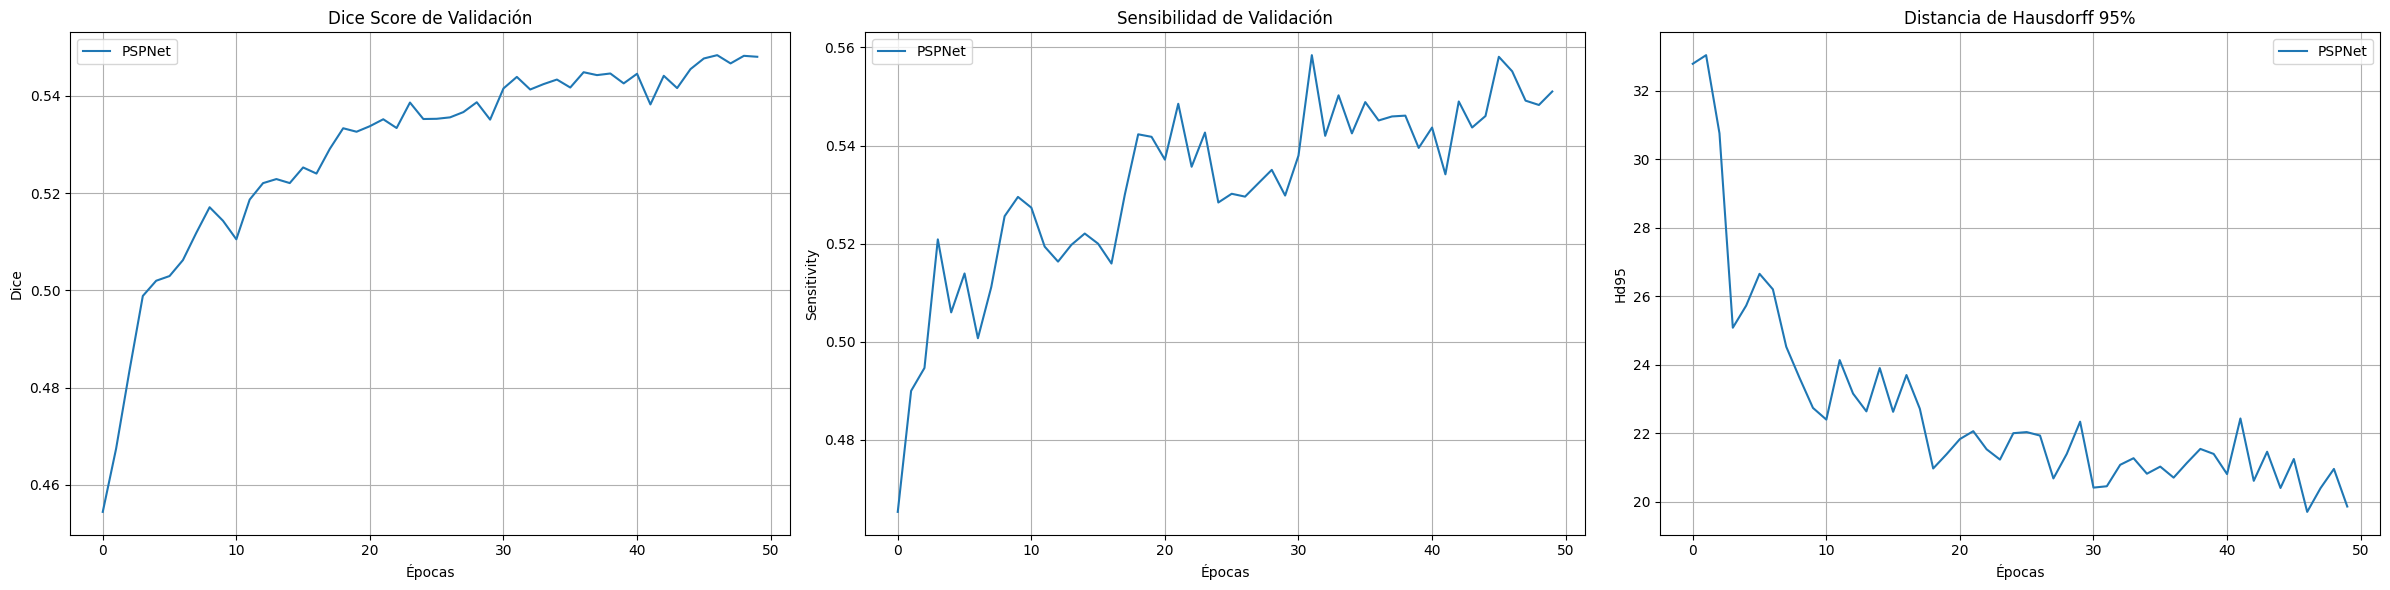

In [18]:
# Visualizar resultados comparativos
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
metrics_to_plot = ['val_dice', 'val_sensitivity', 'val_hd95']
titles = ['Dice Score de Validación', 'Sensibilidad de Validación', 'Distancia de Hausdorff 95%']
for i, metric in enumerate(metrics_to_plot):
    for name, history in results_history.items():
        axes[i].plot(history[metric], label=name)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Épocas')
    axes[i].set_ylabel(metric.replace("val_", "").capitalize())
    axes[i].legend()
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [19]:
print("\n--- Resumen de Mejor Dice Score ---")
for name, score in best_scores.items():
    print(f"{name}: {score:.4f}")



--- Resumen de Mejor Dice Score ---
PSPNet: 0.5483
